# EDA

In [3]:
# import libraries
import numpy as np
import psycopg2
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
import contextily as ctx

In [4]:
# Connect to the database
con =  psycopg2.connect(dbname='carto', user='carto', password='carto', host='postgis', port='5432')

In [5]:
# Query to select only 10,000 pickup data from January
q_jan = '''
            SELECT tpep_pickup_datetime as pickup_time, pickup_point
            FROM taxi_geom
            WHERE tpep_pickup_datetime > '2014-12-31' AND tpep_pickup_datetime <'2015-03-01'
            LIMIT 10000;
        '''

# Save the query result as a geodataframe
pickup_jan = gpd.read_postgis(q_jan, con, geom_col='pickup_point')
pickup_jan.head()

,pickup_time,pickup_point
0,2015-01-01 01:38:28,POINT (-73.94024 40.82033)
1,2015-01-01 01:38:28,POINT (-73.99554 40.76305)
2,2015-01-01 01:38:28,POINT (-73.99630 40.69539)
3,2015-01-01 01:38:28,POINT (-73.97141 40.79787)
4,2015-01-01 01:38:28,POINT (-73.99772 40.69134)


In [83]:
if con:
    con.close()

In [6]:
pickup_jan.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   pickup_time   10000 non-null  datetime64[ns]
 1   pickup_point  10000 non-null  geometry      
dtypes: datetime64[ns](1), geometry(1)
memory usage: 156.4 KB


In [7]:
# Remove missing values if exist
pickup_jan = pickup_jan[~pickup_jan.isnull()]
pickup_jan.shape

(10000, 2)

In [8]:
# Remove duplicated rows
pickup_jan = pickup_jan[~pickup_jan.duplicated()]
pickup_jan.shape

(9997, 2)

In [9]:
print(pickup_jan.crs)

epsg:4326


# More data

* demographic & socio-economic data
* census block group geometries

In [10]:
# Read the demographic and socio-economic data (by block group)
# from the American Community Survey (ACS) dataset
demographic = pd.read_csv('../data/nyc_acs_demographics.csv')
demographic.head()

,Unnamed: 0,geoid,acs_demog_var,value
0,0,360050001001,total_pop,7080.0
1,1,360050001001,two_or_more_races_pop,41.0
2,2,360050001001,vacant_housing_units_for_rent,0.0
3,3,360050001001,unemployed_pop,0.0
4,4,360050001001,black_pop,3984.0


In [11]:
# NYC census block group geometries
census = gpd.read_file('../data/nyc_cbg_geoms.geojson')
print(census.crs)
census.head()

epsg:4326


,geoid,geometry
0,360050001001,"POLYGON ((-73.89277 40.79284, -73.89261 40.792..."
1,360050002001,"POLYGON ((-73.86285 40.81267, -73.86191 40.812..."
2,360050002002,"POLYGON ((-73.86708 40.81444, -73.86332 40.812..."
3,360050002003,"POLYGON ((-73.85856 40.80665, -73.85848 40.806..."
4,360050004001,"POLYGON ((-73.85972 40.81527, -73.85956 40.815..."


In [38]:
census.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 6339 entries, 0 to 6338
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   geoid     6339 non-null   object  
 1   geometry  6339 non-null   geometry
dtypes: geometry(1), object(1)
memory usage: 99.2+ KB


In [79]:
# Reproject data in Web mercator
pickup_jan = pickup_jan.to_crs(epsg=3857)
census = census.to_crs(epsg=3857)

In [80]:
# Select pickup points only within the census block
blocks_union = census.geometry.unary_union
pickups_within_blocks = pickup_jan[pickup_jan.within(blocks_union)]

print(pickups_within_blocks.shape)
pickups_within_blocks.head()

(9978, 2)


,pickup_time,pickup_point
0,2015-01-01 01:38:28,POINT (-8230989.749 4985876.062)
1,2015-01-01 01:38:28,POINT (-8237145.478 4977454.178)
2,2015-01-01 01:38:28,POINT (-8237230.408 4967515.434)
3,2015-01-01 01:38:28,POINT (-8234459.141 4982573.750)
4,2015-01-01 01:38:28,POINT (-8237388.378 4966920.641)


<ipython-input-82-fb3cf81f1abe>:8: FutureWarning: The "url" option is deprecated. Please use the "source" argument instead.
  ctx.add_basemap(ax, url=ctx.providers.Stamen.TonerLite)
No handles with labels found to put in legend.


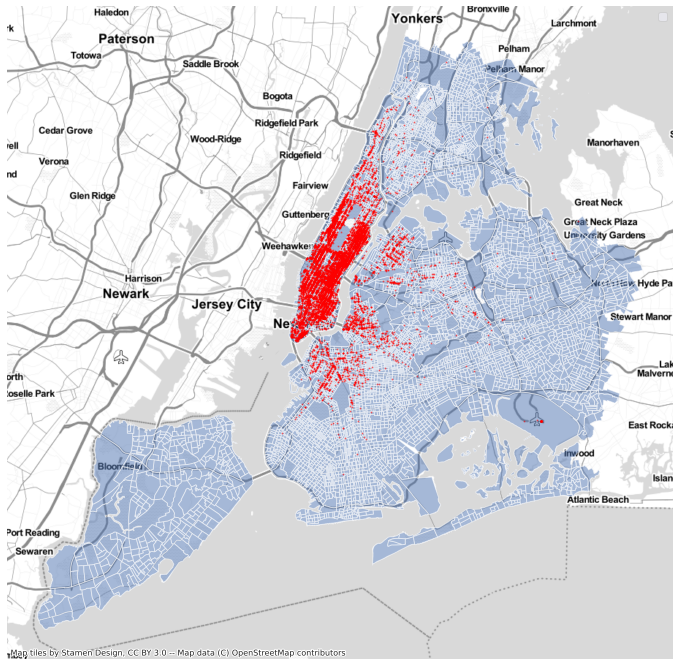

In [82]:
# Plot again the census blocks and pickup points on a basemap
ax = census.plot(figsize=(12, 12), alpha=0.5)

# pickup points within blocks (red points)
pickups_within_blocks.plot(ax=ax, color='red', markersize=1, alpha=.4)

# basemap of NY city
ctx.add_basemap(ax, url=ctx.providers.Stamen.TonerLite)

ax.set_axis_off()
plt.show()

# Merge the taxi and ACS dataset by block group and compute the average number of pickups by block group 